## Model Inference Test

In [1]:
import os, sys
sys.path.append(os.path.join(os.path.abspath(''), '../'))

import peewee as pw
from toyDb.databases import ExperimentDb

import numpy as np
import json
import hashlib

from misc.Directory import (
  getIntermediateDir,
  getVkPredictRootDir
)
from dataset.FragmentPerformanceTracedSnapshotDataset import FragmentPerformanceTracedSnapshotDataset
from dataset.DatasetBuilder import build_dataset
from dataset.MapDataset import MapDataset
from model.ModelBuilder import build_model
from misc.TokenizerBuilder import build_tokenizer
from misc.normalization import (
    LogNormalizer,
    DummyNormalizer
)
from train import (
    TracedDatasetPostProcessor,
    DataCollatorWithPaddingAndTraceEmbedding
)
from misc.metric import compute_metrics
from typing import Union
from collections.abc import Mapping
import torch
import tqdm
import matplotlib.pyplot as plt
from toyDb.utils.spv.SpvContext import getDefaultGrammar
from compete.TracedPerInstLinearRegression import TracedPerInstLinearRegression

ExperimentDb.init_from_default_db()

In [2]:
trainDataset = build_dataset("FragmentPerformanceTracedSnapshotDataset4096-3060", "train")
testDataset = build_dataset("FragmentPerformanceTracedSnapshotDataset4096-3060", "test")

In [3]:
TARGET_MODEL = "perfformer-layer9-regression-trace-input-embedding-xformers-memeff"
MODEL_LOAD_DIR = os.path.join(
    getVkPredictRootDir(), "Perfformer-Rope-Trace-Onehot-Base2-Regression-lr1e-4-log-time-fp16_HfTracedSpvTokenizer-multiple-entrypoint_perfformer-layer9-regression-trace-input-embedding-xformers-memeff/"
)

tokenizer = build_tokenizer("HfTracedSpvTokenizer-multiple-entrypoint")
model = build_model(
    TARGET_MODEL, "mse", 4096,
    tokenizer.bos_token_id, tokenizer.eos_token_id, tokenizer.pad_token_id,
    MODEL_LOAD_DIR
)

print(model)

PerfformerForRegression(
  (perfformer): PerfformerModel(
    (embeddings): PerfformerEmbeddings(
      (word_embeddings): Embedding(40000, 768, padding_idx=1000)
      (position_embeddings): Embedding(4096, 768, padding_idx=1000)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): PerfformerEncoder(
      (layer): ModuleList(
        (0-8): 9 x PerfformerLayer(
          (attention): PerfformerAttention(
            (self): PerfformerSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): PerfformerSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps

In [4]:
def atleast_1d(tensor_or_array: Union[torch.Tensor, np.ndarray]):
    if isinstance(tensor_or_array, torch.Tensor):
        if hasattr(torch, "atleast_1d"):
            tensor_or_array = torch.atleast_1d(tensor_or_array)
        elif tensor_or_array.ndim < 1:
            tensor_or_array = tensor_or_array[None]
    else:
        tensor_or_array = np.atleast_1d(tensor_or_array)
    return tensor_or_array

def torch_pad_and_concatenate(tensor1, tensor2, padding_index=-100):
    """Concatenates `tensor1` and `tensor2` on first axis, applying padding on the second if necessary."""
    tensor1 = atleast_1d(tensor1)
    tensor2 = atleast_1d(tensor2)

    if len(tensor1.shape) == 1 or tensor1.shape[1] == tensor2.shape[1]:
        return torch.cat((tensor1, tensor2), dim=0)

    # Let's figure out the new shape
    new_shape = (tensor1.shape[0] + tensor2.shape[0], max(tensor1.shape[1], tensor2.shape[1])) + tensor1.shape[2:]

    # Now let's fill the result tensor
    result = tensor1.new_full(new_shape, padding_index)
    result[: tensor1.shape[0], : tensor1.shape[1]] = tensor1
    result[tensor1.shape[0] :, : tensor2.shape[1]] = tensor2
    return result


def numpy_pad_and_concatenate(array1, array2, padding_index=-100):
    """Concatenates `array1` and `array2` on first axis, applying padding on the second if necessary."""
    array1 = atleast_1d(array1)
    array2 = atleast_1d(array2)

    if len(array1.shape) == 1 or array1.shape[1] == array2.shape[1]:
        return np.concatenate((array1, array2), axis=0)

    # Let's figure out the new shape
    new_shape = (array1.shape[0] + array2.shape[0], max(array1.shape[1], array2.shape[1])) + array1.shape[2:]

    # Now let's fill the result tensor
    result = np.full_like(array1, padding_index, shape=new_shape)
    result[: array1.shape[0], : array1.shape[1]] = array1
    result[array1.shape[0] :, : array2.shape[1]] = array2
    return result


def nested_concat(tensors, new_tensors, padding_index=-100):
    """
    Concat the `new_tensors` to `tensors` on the first dim and pad them on the second if needed. Works for tensors or
    nested list/tuples/dict of tensors.
    """
    assert type(tensors) == type(
        new_tensors
    ), f"Expected `tensors` and `new_tensors` to have the same type but found {type(tensors)} and {type(new_tensors)}."
    if isinstance(tensors, (list, tuple)):
        return type(tensors)(nested_concat(t, n, padding_index=padding_index) for t, n in zip(tensors, new_tensors))
    elif isinstance(tensors, torch.Tensor):
        return torch_pad_and_concatenate(tensors, new_tensors, padding_index=padding_index)
    elif isinstance(tensors, Mapping):
        return type(tensors)(
            {k: nested_concat(t, new_tensors[k], padding_index=padding_index) for k, t in tensors.items()}
        )
    elif isinstance(tensors, np.ndarray):
        return numpy_pad_and_concatenate(tensors, new_tensors, padding_index=padding_index)
    else:
        raise TypeError(f"Unsupported type for concatenation: got {type(tensors)}")


In [5]:
trainDatasetMapped = MapDataset(trainDataset, TracedDatasetPostProcessor, [tokenizer, LogNormalizer(), DummyNormalizer()])
testDatasetMapped = MapDataset(testDataset, TracedDatasetPostProcessor, [tokenizer, LogNormalizer(), DummyNormalizer()])

dataCollator = DataCollatorWithPaddingAndTraceEmbedding(
    tokenizer=tokenizer,
    trace_embedding_method="onehot-base2",
    trace_embedding_dim=model.config.hidden_size,
    padding='longest',
    pad_to_multiple_of=8
)

testLoader = torch.utils.data.DataLoader(
    testDatasetMapped,
    batch_size=4,
    shuffle=False,
    collate_fn=dataCollator
)

trainLoader = torch.utils.data.DataLoader(
    trainDatasetMapped,
    batch_size=4,
    shuffle=False,
    collate_fn=dataCollator
)

evalModelOnTestDataset = False
evalModelOnTrainDataset = True

if evalModelOnTestDataset:
    model.eval()

    INFERENCE_DEVICE = 'cuda'
    model.to(INFERENCE_DEVICE)

    labels = np.asarray([], dtype=np.float32)
    preds = np.asarray([], dtype=np.float32)

    with torch.no_grad():
        for model_inputs in tqdm.tqdm(testLoader):
            for k in model_inputs.keys():
                model_inputs[k] = model_inputs[k].to(INFERENCE_DEVICE)

            outputs = model(**model_inputs)
            labels = nested_concat(labels, model_inputs['labels'].cpu().numpy())
            preds = nested_concat(preds, outputs['logits'].squeeze(1).cpu().numpy())

    np.save("preds.npy", preds)
    np.save("labels.npy", labels)
else:
    preds = np.load("preds.npy")
    labels = np.load("labels.npy")

if evalModelOnTrainDataset:
    model.eval()

    INFERENCE_DEVICE = 'cuda'
    model.to(INFERENCE_DEVICE)

    labels_train = np.asarray([], dtype=np.float32)
    preds_train = np.asarray([], dtype=np.float32)

    with torch.no_grad():
        for model_inputs in tqdm.tqdm(trainLoader):
            for k in model_inputs.keys():
                model_inputs[k] = model_inputs[k].to(INFERENCE_DEVICE)

            outputs = model(**model_inputs)
            labels_train = nested_concat(labels_train, model_inputs['labels'].cpu().numpy())
            preds_train = nested_concat(preds_train, outputs['logits'].squeeze(1).cpu().numpy())

    np.save("preds_train.npy", preds_train)
    np.save("labels_train.npy", labels_train)
else:
    preds_train = np.load("preds_train.npy")
    labels_train = np.load("labels_train.npy")

100%|██████████| 2255/2255 [22:15<00:00,  1.69it/s]


In [21]:
shaderId_train = []
shaderId_test = []

for idx in tqdm.tqdm(range(len(trainDataset))):
  shaderId_train.append(trainDataset[idx]['shaderId'])

for idx in tqdm.tqdm(range(len(testDataset))):
  shaderId_test.append(testDataset[idx]['shaderId'])

100%|██████████| 2255/2255 [00:00<00:00, 81984.62it/s]


In [6]:
preds

array([ -9.499601, -10.738271,  -6.271552, ...,  -5.72359 ,  -8.644011,
        -6.384191], dtype=float32)

In [7]:
labels

array([ -8.629544 , -10.960937 ,  -6.470844 , ...,  -4.8659086,
        -8.889734 ,  -5.4753685], dtype=float32)

In [8]:
preds_orig = LogNormalizer().invNormalize(preds)
labels_orig = LogNormalizer().invNormalize(labels)

In [9]:
preds_orig

array([7.4881675e-05, 2.1698426e-05, 1.8892939e-03, ..., 3.2679581e-03,
       1.7617890e-04, 1.6880335e-03], dtype=float32)

In [10]:
labels_orig

array([1.7874608e-04, 1.7367038e-05, 1.5479190e-03, ..., 7.7048242e-03,
       1.3779628e-04, 4.1886847e-03], dtype=float32)

In [11]:
compute_metrics(preds_orig, labels_orig)

{'mse_sqrt': 0.003353461,
 'mae': 0.00051580823,
 'mape': 0.38658652,
 'mse_sqrt_ge_10000fps': 4.442574e-05,
 'mae_ge_10000fps': 1.0795967e-05,
 'mape_ge_10000fps': 0.3216701,
 'mse_sqrt_ge_1000_le_10000fps': 0.00033933946,
 'mae_ge_1000_le_10000fps': 0.00017962055,
 'mape_ge_1000_le_10000fps': 0.49443203,
 'mse_sqrt_ge_100_le_1000fps': 0.0019933293,
 'mae_ge_100_le_1000fps': 0.0013713095,
 'mape_ge_100_le_1000fps': 0.4571594,
 'mse_sqrt_ge_10_le_100fps': 0.018747745,
 'mae_ge_10_le_100fps': 0.01432042,
 'mape_ge_10_le_100fps': 0.6581144,
 'mse_sqrt_le_10fps': 0.1052712,
 'mae_le_10fps': 0.1052712,
 'mape_le_10fps': 0.47058207}

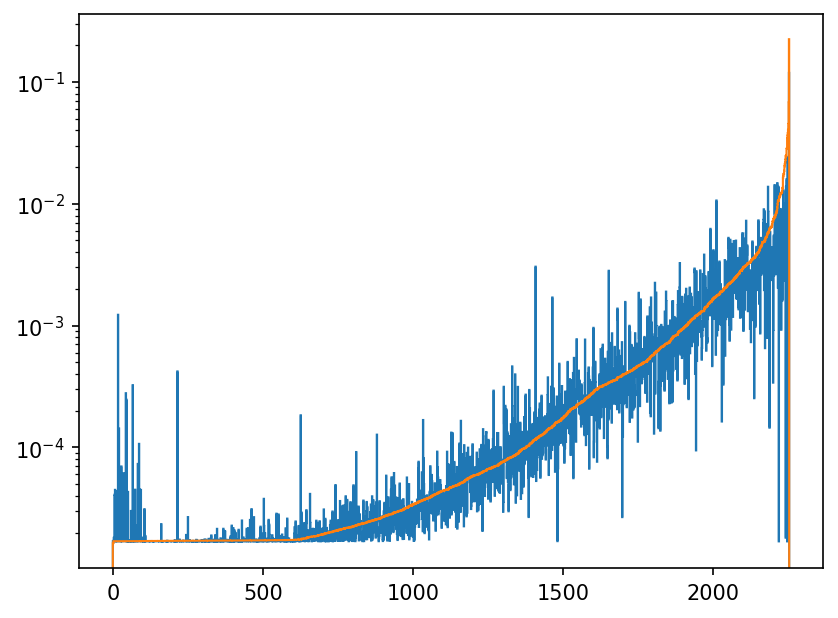

In [12]:
labelSortIndices = np.argsort(labels_orig)
predOrigSorted = preds_orig[labelSortIndices]
labelOrigSorted = labels_orig[labelSortIndices]

plt.rcParams['figure.dpi'] = 150
fig, ax = plt.subplots()

ax.set_yscale('log')
# axPred.set_xlabel('Ordinal by timeMean[0]')
# axStd.set_ylim(bottom=1e-10, top=1e-3)

ax.stairs(predOrigSorted)
ax.stairs(labelOrigSorted)

In [13]:
grammar = getDefaultGrammar()
regressor = TracedPerInstLinearRegression(grammar, True, True)
regressor.train(trainDataset)

print(f"- Model coef: {regressor.model.coef_}")
print(f"- Model intercept: {regressor.model.intercept_}")

Y_real, Y_pred = regressor.evaluate(testDataset)

Training:  32%|███▏      | 2911/9019 [00:15<00:29, 209.07it/s, id=WdK3zd]Basic block #15 not in traced block list. 
Basic block #46 not in traced block list. 
Training:  57%|█████▋    | 5177/9019 [00:26<00:20, 188.25it/s, id=ltsyWl]Basic block #12 not in traced block list. 
Basic block #73 not in traced block list. 
Basic block #77 not in traced block list. 
Basic block #74 not in traced block list. 
Basic block #76 not in traced block list. 
Basic block #75 not in traced block list. 
Training: 100%|██████████| 9019/9019 [00:45<00:00, 196.42it/s, id=ttVfzR]


model coef_=[ 1.93773407e-18  6.51589616e-10  6.73877187e-14 -1.89316930e-11
  2.26183326e-11  1.32391060e-13 -8.27217093e-13  7.39994524e-12
 -3.00481168e-11  3.60648247e-11  1.35664041e-11  1.57916701e-11
 -1.32879992e-11  2.90213795e-12  3.02051700e-12  1.20120331e-13
  1.87294169e-12 -1.35919973e-11 -1.96902061e-11 -1.52294215e-12
 -3.83084319e-12  1.20570936e-12  1.14852954e-11 -2.58646403e-12
  4.91480728e-12  2.60763026e-12 -1.73944401e-11  7.59371298e-12
 -4.30267584e-13 -7.03136291e-12  5.36212524e-12  2.22600887e-12
 -1.47452779e-11 -7.35923854e-13  4.69141219e-13  1.25885576e-13
 -3.28104460e-13 -2.08577106e-13  2.80167599e-14 -1.13595873e-13
 -4.38814431e-13  4.69032365e-14 -3.24115355e-13  4.55304197e-14
 -9.53031057e-14 -4.32321822e-14 -3.73188676e-13 -7.93850662e-14
 -4.74997103e-14  2.81522201e-13 -6.25042552e-15  6.19959813e-14
  6.25407929e-14  1.60716059e-13 -2.14040591e-13 -8.48323148e-15
 -7.15585360e-14 -1.74218821e-14 -4.69136882e-13  1.79791078e-14
  8.35299711e

Evaluation: 100%|██████████| 2255/2255 [00:10<00:00, 224.98it/s]


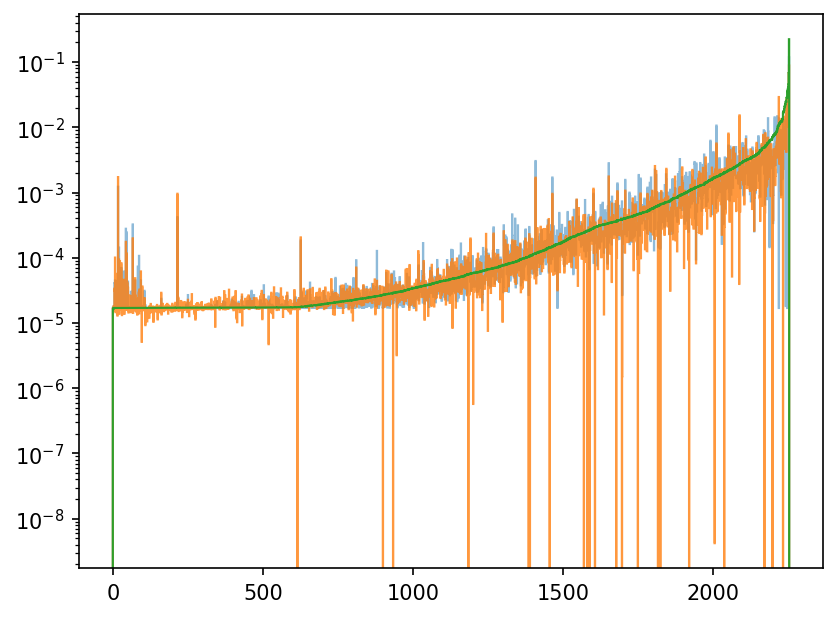

In [14]:
linRegPredsSorted = Y_pred[labelSortIndices]

plt.rcParams['figure.dpi'] = 150
fig, ax = plt.subplots()

ax.set_yscale('log')
# axPred.set_xlabel('Ordinal by timeMean[0]')
# axStd.set_ylim(bottom=1e-10, top=1e-3)

ax.stairs(predOrigSorted, alpha=0.5)
ax.stairs(linRegPredsSorted, alpha=0.8)
ax.stairs(labelOrigSorted)

In [15]:
np.mean(1.0 / labels_orig * (preds_orig - labels_orig)**2)

0.00048328153

In [16]:
np.mean(1.0 / Y_real * (Y_pred - Y_real)**2)

0.00050342985

In [17]:
Y_real_train, Y_pred_train = regressor.evaluate(trainDataset)

Evaluation:  32%|███▏      | 2921/9019 [00:13<00:28, 214.55it/s]Basic block #15 not in traced block list. 
Basic block #46 not in traced block list. 
Evaluation:  57%|█████▋    | 5184/9019 [00:23<00:14, 256.88it/s]Basic block #12 not in traced block list. 
Basic block #73 not in traced block list. 
Basic block #77 not in traced block list. 
Basic block #74 not in traced block list. 
Basic block #76 not in traced block list. 
Basic block #75 not in traced block list. 
Evaluation: 100%|██████████| 9019/9019 [00:40<00:00, 220.20it/s]


In [18]:
np.mean(1.0 / Y_real_train * (Y_pred_train - Y_real_train)**2)

0.00034522443

In [19]:
preds_train_orig = LogNormalizer().invNormalize(preds_train)
labels_train_orig = LogNormalizer().invNormalize(labels_train)

np.mean(1.0 / labels_train_orig * (preds_train_orig - labels_train_orig)**2)

2.1252397e-05

In [37]:
print("Transformer (deviation) | LinReg (deviation) | Ground truth | shaderID ")
for idx in range(len(testDataset)):
  record = f"{predOrigSorted[idx]:.4e} ({(predOrigSorted[idx] - labelOrigSorted[idx]) / labelOrigSorted[idx] * 100:7.2f}%)"
  record += " | "
  record += f"{linRegPredsSorted[idx]:.4e} ({(linRegPredsSorted[idx] - labelOrigSorted[idx]) / labelOrigSorted[idx] * 100:7.2f}%)"
  record += " | "
  record += f"{labelOrigSorted[idx]:.4e}"
  record += " | "
  record += shaderId_test[labelSortIndices[idx]]
  print(record)

Transformer (deviation) | LinReg (deviation) | Ground truth | shaderID 
1.6993e-05 (   3.83%) | 1.6751e-05 (   2.35%) | 1.6367e-05 | 3djGzV
1.6950e-05 (   3.09%) | 1.5159e-05 (  -7.80%) | 1.6442e-05 | dsBGzW
1.7108e-05 (   0.69%) | 1.7901e-05 (   5.35%) | 1.6992e-05 | XdVXR3
1.8116e-05 (   6.60%) | 1.6189e-05 (  -4.74%) | 1.6995e-05 | 4dsBRl
1.6989e-05 (  -0.06%) | 1.7773e-05 (   4.56%) | 1.6998e-05 | 4dGGzD
4.0108e-05 ( 135.95%) | 3.3583e-05 (  97.57%) | 1.6998e-05 | MdGcWW
4.0972e-05 ( 141.04%) | 3.1203e-05 (  83.56%) | 1.6998e-05 | 7slfRH
4.4873e-05 ( 163.98%) | 1.0076e-04 ( 492.74%) | 1.6998e-05 | 3l3XRN
1.7257e-05 (   1.52%) | 2.8257e-05 (  66.23%) | 1.6998e-05 | 4d3BWH
1.6947e-05 (  -0.30%) | 1.4620e-05 ( -13.99%) | 1.6998e-05 | slscDN
3.6685e-05 ( 115.81%) | 3.6224e-05 ( 113.10%) | 1.6998e-05 | Nssfz4
4.3667e-05 ( 156.89%) | 5.6573e-05 ( 232.81%) | 1.6998e-05 | 3ltfW2
1.7263e-05 (   1.55%) | 1.8670e-05 (   9.83%) | 1.6998e-05 | Ms2BzG
1.6946e-05 (  -0.31%) | 1.5252e-05 ( -10.27%

Blacklist shader with result image hash bbd05cf6097ac9b1f89ea29d2542c1b7b67ee46848393895f5a9e43fa1f621e5, which is completely dark.

In [39]:
blackShaderIds = """XlyyRy
7syXzV
wsBGWz
fldyWM
tlXfR8
tdlSRn
fl2SRG
3sGyzw
4syfDV
3lsyWs
ltlyzr
4lSfWK
tlcSWf
ldKSRt
tlfcR8
wsX3zN
ldKfD3
XlXXzH
7sjfWV
3ljyWt
MsGcDt
MdKXDD
XdGfWt
Xtc3RB
st23zh
XtlXRB
XlcGW7
tsVSR1
WltfWr
MlfcDn
DtfGDX
ldjfzm
NscXR4
XslXWn
XsKcDy
flGGR3
sdyfRy
Ws3BD2
lsdfD8
XdVXzG
dtfXDM
Mllfzf
XtdyWN
lljyWh
3lScRR
Xdt3D8
lslBDj
ftVcWd
4tSXWd
XsGfWd
7sXGRM
WlXyRN
wtjyRW
XlKGDz
XtfXzH
3ldfWr
WlVczz
tdXGRH
MdyXWw
4tdGWs
cslSDr
XltfDn
MdVcRd
XllyWS
4tXfW8
4tXXzH
WdtyR2
Msc3WN
wsXyWf
MldBWr
tlsGR8
Nt3GWr
Ml3cDS
XddBD8
XtyfDc
DlSXzy
WdGXWG
MtffzB
ttdGR2
7djfWV
slKGzV
tsyXzV
ldG3Dw
wdlfDH
MsVyWV
cstSWH
cllSzl
ll2cRR
wdd3R7
fsBcDG
MldyDN
3lyyWh
ttGGzD
XlsyWX
MddfR7
MljBDG
4sdBz2
4ly3Ry
lslfDS
NstSD4
Wstyzl
slccz7
4ttBD4
ldBfWz
4dGBWd
3sdGRN
7dsBDn
wljyz1
3dcBW2
WdBSWR
MtXBW7
DlSXD1
fddXWN
XtySRK
XdsBRl
3t2SWd
4dSBW1
4lXXzH
WldSWj
3dGfD1
wt3fWr
ltVGW3
fsf3WX
mtSSDh
3ddcR4
3ll3RS
4s2yzd
4sVXR3
3tcBz7
wdcfzr
WlVXzK
MssBWj
WddcWB
3scfDj
3sKXzy
XlfBW7
fdt3zj
7d3yRM
MtfBRf
4dtfW8
tdtBDj
7dlfDn
sdt3Dl
ttKSDm
XdSBzW
ltKGzD
lsGyWW
tsyXRh
MscGDf
4l3SR4
llGGW1
wd33R7
Mlc3zn
ttBczh
Xlffzj
lt2XRD
4ljBWd
MlGGW1
sl3GWn
td3fWj
wtVSzK
Xl3cRs
wd3GR7
Dl2SWR
3t2fRt
dtlSRH
4sKfD3
ldtfDN
4tVGWw
MsG3Dy
MscfWM
XstBWn
XlXBWS
3ldBzM
XdyBWd
4sdBWn
ttXSWX
ll2fWG
wljfzz
lscGz4
4ld3WB
WtfczH
msfSDl
XstfWn
NdByzd
ldyBzm
3djcDy
MdGcWW
MstBR7
DldGDf
wsXGWM
Ml3cD7
Wsd3Dr
4dKSDV
3djGzV
wsjGW3
4ldGDM
sl2XR3
XsdyR7
ssBczW
XtXXzH
4sdGD8
wsySRR
4lGyWR
DtjGWd
7ssfWn
3df3R8
wdcyW2
lty3R3
Ws3cWl
XsKXzG
sdKSzc
DdtSzB
MtjfDG
wdlfDX
XsyBWd
4sKXzy
wd2GW1
4sGczz
tdcGRs
XdKXz3
4t3SD7
td3BDn
4s33Rr
wl3fWr
3ltGRj
4sGSWm
dtV3RG
sdscRr
MdVSR1
wsGGzh
3sXSW8
3tdfWr
XsdBW8
4dt3RH
4lGfDd
tdlfWX
MsKGDV
wsG3z3
MlycRc
DsXSDr
3lsyWS
tddfWj
4lXfDr
XsGBWd
4sK3Dz
sljXRz
XtSfDV
wtsczN
Nds3RM
MlsXDr
Dt2SWR
llKcDm
3tjyDR
XddfW8
ct2SWR
wssfWX
ldGGDt
tlKXDh
lsKXRG
ltdcRn
4scGWf
NdGXR3
XddBWn
XsKXz3
XlV3Wm
4lffDr
4tjyDz
WlVXDW
WsGXDy
4dVfD3
wdBczG
4dsBRl
4dtfWr
wsd3R7
ldjcD3
ldjBW1
ddS3RR
MsGyWK
tdS3Wz
ls33DN
4syBWd
wtG3zw
tlB3R1
tslBWf
3lGXRG
fsjcDV
XsSGzG
tdG3R1
XljBRh
3tfXRj
Ms2BzG
cs3XDf
7d3GD8
WtVSDt
4dGyDt
WdsSWM
tt2fzG
XdySRt
MdK3Wt
MtBcR1
ttd3D7
XdtBWn
WtVXDW
ltccD7
ssVSzt
wtBfRm
4d3BWH
WsfGz4
sdXfWB
XldXRN
Xllfzj
WtVXRc
MtVfW3
XddfRX
XdtfW8
WtXyRN
4dlBW2
cdy3Dd
lsKXzy
7dGXzK
ltXcDn
lsSBWh
XdVXR3
llfyDn
4stcRM
tlSfRz
dtsXRB
4sSXWR
ll3Bzr
Mt3GDS
4stfRX
cdK3D3
NsySRy
ldjBzh
sllSRH
4l2cW1
MtVGzD
wtSczh
4tcXRM
sdGXWD
ddX3DM
XdXyDr
wdXBDs
XlGGD3
WsfGRN
ldBBDh
4sdBW8
WtSBR1
XsffWl
lscfDr
XdKXWh
ll23WK
Ml2Bz1
ttlcDs
dscSRH
4sd3RH
ldySDG
4lGfDc
wslBWf
ms3XWl
4sdBD8
XsdfRX
4sycRD
ll2XWV
MtKGzD
tdjfRd
3tKGWR
tdtcWB
3lyGRW
MdKBD3
fsdyzj
7tXcWS
tdXfDB
4lSfWV
4lt3z4
MtSSWw
mdt3D7
MdcBDr
NddGzn
Ws3yD2
4tcXR4
WscGWH
NstSWN
WtXfzH
WltBzM
ld3fDr
WtdfWr
Ml3cDB
Wds3zf
ttsyWn
XtV3Wz
WssfRj
ltlfRf
3s3BW2
dljGzW
7ssyRS
3lsfR4
wsccWB
stGXzK
4scXWB
MsjfRz
ttBBzz
WtsczX
ldlyD2
3tGXRG
wtVBWK
fd2fzy
MscfDr
ltVBDG
sl3cWH
3slyDN
XstfW8
XlG3DR
tddXDf
MsjfRm
lsVXRw
Nt2GWy
tsySzz
3dVcWd
4stfWn
7ldcWn
ltBXDd
WsGBWm
wddGz7
ttjBzz
fdcGRH
4dGGzD
fdjcDV
3sGXWK
4t2yDy
3dsGzn
wlcSWf
4dG3DV
4dG3WK
3dKczV
4ddfW8
tdsGRX
flK3zc
lsKBWc
Mlfyzn
XdtfD8
4ddGzH
ldVGzK
Xd3BWH
lsXyWN
wdKXzd
sd2BDV
XddXDM
lsdBR7
XsV3Dz
Nt3cD4
wsKSWK
ldGSDG
""".split()

In [40]:
filteredIndices = []
for shdrId in blackShaderIds:
  if shdrId not in shaderId_test:
    continue
  
  idx = shaderId_test.index(shdrId)
  filteredIndices.append(idx)

validIndices = []
for idx in range(0, len(testDataset)):
  if idx in filteredIndices:
    continue
  else:
    validIndices.append(idx)

In [44]:
preds_orig_filtered = np.asarray([preds_orig[idx] for idx in validIndices])
labels_orig_filtered = np.asarray([labels_orig[idx] for idx in validIndices])

compute_metrics(preds_orig_filtered, labels_orig_filtered)

/home/libreliu/Projects/NGPP/vkPredict/notebooks/../misc/metric.py:39: RuntimeWarning: Mean of empty slice.
  ((candRealTime - candPredTime)**2).mean(axis=0)
/home/libreliu/Projects/NGPP/vkPredict/venv/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/libreliu/Projects/NGPP/vkPredict/venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


{'mse_sqrt': 0.0025662812,
 'mae': 0.0004833529,
 'mape': 0.3464471,
 'mse_sqrt_ge_10000fps': 2.9477333e-05,
 'mae_ge_10000fps': 9.899323e-06,
 'mape_ge_10000fps': 0.2500948,
 'mse_sqrt_ge_1000_le_10000fps': 0.0003396344,
 'mae_ge_1000_le_10000fps': 0.00017957101,
 'mape_ge_1000_le_10000fps': 0.49532703,
 'mse_sqrt_ge_100_le_1000fps': 0.001954317,
 'mae_ge_100_le_1000fps': 0.0013560249,
 'mape_ge_100_le_1000fps': 0.45741436,
 'mse_sqrt_ge_10_le_100fps': 0.018747745,
 'mae_ge_10_le_100fps': 0.01432042,
 'mape_ge_10_le_100fps': 0.6581144,
 'mse_sqrt_le_10fps': nan,
 'mae_le_10fps': nan,
 'mape_le_10fps': nan}

In [45]:
Y_pred_filtered = np.asarray([Y_pred[idx] for idx in validIndices])
compute_metrics(Y_pred_filtered, labels_orig_filtered)

/home/libreliu/Projects/NGPP/vkPredict/notebooks/../misc/metric.py:39: RuntimeWarning: Mean of empty slice.
  ((candRealTime - candPredTime)**2).mean(axis=0)
/home/libreliu/Projects/NGPP/vkPredict/venv/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/libreliu/Projects/NGPP/vkPredict/venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


{'mse_sqrt': 0.0019176824,
 'mae': 0.0004514323,
 'mape': 0.3849435,
 'mse_sqrt_ge_10000fps': 3.312245e-05,
 'mae_ge_10000fps': 1.0452024e-05,
 'mape_ge_10000fps': 0.30929774,
 'mse_sqrt_ge_1000_le_10000fps': 0.00028953326,
 'mae_ge_1000_le_10000fps': 0.00018041344,
 'mape_ge_1000_le_10000fps': 0.48111323,
 'mse_sqrt_ge_100_le_1000fps': 0.0024644705,
 'mae_ge_100_le_1000fps': 0.0015864773,
 'mape_ge_100_le_1000fps': 0.51637,
 'mse_sqrt_ge_10_le_100fps': 0.012814968,
 'mae_ge_10_le_100fps': 0.010572062,
 'mape_ge_10_le_100fps': 0.57175344,
 'mse_sqrt_le_10fps': nan,
 'mae_le_10fps': nan,
 'mape_le_10fps': nan}

In [47]:
print("Transformer (deviation) | LinReg (deviation) | Ground truth | shaderID ")
for idx in range(len(testDataset)):
  if shaderId_test[labelSortIndices[idx]] in blackShaderIds:
    continue
  record = f"{predOrigSorted[idx]:.4e} ({(predOrigSorted[idx] - labelOrigSorted[idx]) / labelOrigSorted[idx] * 100:7.2f}%)"
  record += " | "
  record += f"{linRegPredsSorted[idx]:.4e} ({(linRegPredsSorted[idx] - labelOrigSorted[idx]) / labelOrigSorted[idx] * 100:7.2f}%)"
  record += " | "
  record += f"{labelOrigSorted[idx]:.4e}"
  record += " | "
  record += shaderId_test[labelSortIndices[idx]]
  print(record)

Transformer (deviation) | LinReg (deviation) | Ground truth | shaderID 
1.6950e-05 (   3.09%) | 1.5159e-05 (  -7.80%) | 1.6442e-05 | dsBGzW
4.0972e-05 ( 141.04%) | 3.1203e-05 (  83.56%) | 1.6998e-05 | 7slfRH
4.4873e-05 ( 163.98%) | 1.0076e-04 ( 492.74%) | 1.6998e-05 | 3l3XRN
1.6947e-05 (  -0.30%) | 1.4620e-05 ( -13.99%) | 1.6998e-05 | slscDN
3.6685e-05 ( 115.81%) | 3.6224e-05 ( 113.10%) | 1.6998e-05 | Nssfz4
4.3667e-05 ( 156.89%) | 5.6573e-05 ( 232.81%) | 1.6998e-05 | 3ltfW2
1.7099e-05 (   0.59%) | 1.2975e-05 ( -23.67%) | 1.6998e-05 | NtcGzN
1.7155e-05 (   0.90%) | 1.8942e-05 (  11.41%) | 1.7002e-05 | mtc3Wr
1.4289e-04 ( 740.43%) | 9.3794e-05 ( 451.67%) | 1.7002e-05 | tdBGRW
6.9792e-05 ( 310.50%) | 8.2442e-05 ( 384.90%) | 1.7002e-05 | wtcBWf
6.1461e-05 ( 261.42%) | 4.5948e-05 ( 170.20%) | 1.7005e-05 | 3ddXWB
4.1874e-05 ( 146.24%) | 2.9026e-05 (  70.69%) | 1.7005e-05 | 3tByzw
1.6981e-05 (  -0.14%) | 2.0148e-05 (  18.48%) | 1.7005e-05 | sdyBDK
1.6944e-05 (  -0.38%) | 1.6837e-05 (  -1.01%